#Setup Environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import pandas
import pandas as pd
import matplotlib.pyplot as plt
# Read Excel file with multiple sheets
xls = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/2. MER PointTransaction 2023_RetailsResellers_Final.xlsx", sheet_name=['MER Transaction', 'Point Per Litre'])

# Access individual sheets using sheet names
MER_df = xls['MER Transaction']
PPL_df = xls['Point Per Litre']

In [ ]:
import datetime

In [ ]:
MER_df.head()

,Invoicedate,Distributor,GroupId,Type,Provincename,MatNo,Material Name,New_Volume(L)
0,2023-09-06,A,ERW_AMBP2020110207,Reseller,Chachoengsao,145577,M SUP Frict Fighter TBS 10W-30 4x7L/CAR,11676
1,2023-12-20,A,ERW_AMBP2020110207,Reseller,Chachoengsao,145577,M SUP Frict Fighter TBS 10W-30 4x7L/CAR,5768
2,2023-08-11,A,ERW_AMBP2020110207,Reseller,Chachoengsao,143160,MOBIL DELVAC SUPER1400 15W-40 4X6+1L/CAR,11088
3,2023-03-10,A,ERW_AMBP2020110291,Reseller,Nakhon Ratchasima,143160,MOBIL DELVAC SUPER 1400 15W-40 4X6+1/CAR,2912
4,2023-03-10,A,ERW_AMBP2020110291,Reseller,Nakhon Ratchasima,143160,MOBIL DELVAC SUPER1400 15W-40 4X6+1L/CAR,7168


In [ ]:
PPL_df.head()

,MatNo,Points
0,144673,10
1,140521,10
2,144473,10
3,145832,10
4,140418,10


In [ ]:
nan_values = MER_df.isnull().sum()

print(nan_values)

Invoicedate      0
Distributor      0
GroupId          0
Type             0
Provincename     0
MatNo            0
Material Name    0
New_Volume(L)    0
dtype: int64


#Feature Engineering

In [ ]:
df = MER_df.merge(PPL_df, on='MatNo', how='left')

In [ ]:
df['Invoicedate'] = pd.to_datetime(df['Invoicedate'])

In [ ]:
df

,Invoicedate,Distributor,GroupId,Type,Provincename,MatNo,Material Name,New_Volume(L),Points
0,2023-09-06,A,ERW_AMBP2020110207,Reseller,Chachoengsao,145577,M SUP Frict Fighter TBS 10W-30 4x7L/CAR,11676,2
1,2023-12-20,A,ERW_AMBP2020110207,Reseller,Chachoengsao,145577,M SUP Frict Fighter TBS 10W-30 4x7L/CAR,5768,2
2,2023-08-11,A,ERW_AMBP2020110207,Reseller,Chachoengsao,143160,MOBIL DELVAC SUPER1400 15W-40 4X6+1L/CAR,11088,2
3,2023-03-10,A,ERW_AMBP2020110291,Reseller,Nakhon Ratchasima,143160,MOBIL DELVAC SUPER 1400 15W-40 4X6+1/CAR,2912,2
4,2023-03-10,A,ERW_AMBP2020110291,Reseller,Nakhon Ratchasima,143160,MOBIL DELVAC SUPER1400 15W-40 4X6+1L/CAR,7168,2
...,...,...,...,...,...,...,...,...,...
9424,2023-03-11,C,ERW_C08P2020090135,Retails,Lampang,140417,"MOBIL 1 TURBO DIESEL 5W-40, 12X1LT CTN",281,10
9425,2023-07-18,C,ERW_C08P2020090145,Retails,Chiang Mai,140417,"MOBIL 1 TURBO DIESEL 5W-40, 12X1LT CTN",354,10
9426,2023-10-19,C,ERW_C08P2020090203,Retails,Chiang Mai,140635,"MOBIL 1 FS X2 5W50, 12X1L CTN",281,10
9427,2023-11-29,C,ERW_C08P2020090203,Retails,Chiang Mai,140635,"MOBIL 1 FS X2 5W50, 12X1L CTN",162,10


In [ ]:
#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final


In [ ]:
data = pd.DataFrame(df['GroupId'].unique())
data.columns = ['GroupId']
data

,GroupId
0,ERW_AMBP2020110207
1,ERW_AMBP2020110291
2,ERW_BM2U2020110053
3,ERW_C08P2020090096
4,ERW_BM2U2020110177
...,...
632,ERW_AMBP2020110762
633,ERW_C08P2020090018
634,ERW_C08P2020090132
635,ERW_C9H62020120015


In [ ]:
df_Q1 = df.loc[df['Invoicedate'].dt.quarter == 1]
tx_max_purchase_Q1 = df_Q1.groupby('GroupId').Invoicedate.max().reset_index()
tx_max_purchase_Q1.columns = ['GroupId','MaxPurchaseDate_Q1']
tx_max_purchase_Q1['Recency_Q1'] = (datetime.datetime(2023, 3, 31) - tx_max_purchase_Q1['MaxPurchaseDate_Q1']).dt.days
data = pd.merge(data, tx_max_purchase_Q1, on='GroupId', how='left')
data['Recency_Q1'].fillna((datetime.datetime(2023, 3, 31) - datetime.datetime(2023, 1, 1)).days,inplace=True)

df_Q2 = df.loc[df['Invoicedate'].dt.quarter == 2]
tx_max_purchase_Q2 = df_Q2.groupby('GroupId').Invoicedate.max().reset_index()
tx_max_purchase_Q2.columns = ['GroupId','MaxPurchaseDate_Q2']
tx_max_purchase_Q2['Recency_Q2'] = (datetime.datetime(2023, 6, 30) - tx_max_purchase_Q2['MaxPurchaseDate_Q2']).dt.days
data = pd.merge(data, tx_max_purchase_Q2, on='GroupId', how='left')
data['Recency_Q2'].fillna((datetime.datetime(2023, 6, 30) - datetime.datetime(2023, 4, 1)).days,inplace=True)

df_Q3 = df.loc[df['Invoicedate'].dt.quarter == 3]
tx_max_purchase_Q3 = df_Q3.groupby('GroupId').Invoicedate.max().reset_index()
tx_max_purchase_Q3.columns = ['GroupId','MaxPurchaseDate_Q3']
tx_max_purchase_Q3['Recency_Q3'] = (datetime.datetime(2023, 9, 30) - tx_max_purchase_Q3['MaxPurchaseDate_Q3']).dt.days
data = pd.merge(data, tx_max_purchase_Q3, on='GroupId', how='left')
data['Recency_Q3'].fillna((datetime.datetime(2023, 9, 30) - datetime.datetime(2023, 7, 1)).days,inplace=True)

df_Q4 = df.loc[df['Invoicedate'].dt.quarter == 4]
tx_max_purchase_Q4 = df_Q4.groupby('GroupId').Invoicedate.max().reset_index()
tx_max_purchase_Q4.columns = ['GroupId','MaxPurchaseDate_Q4']
tx_max_purchase_Q4['Recency_Q4'] = (datetime.datetime(2023, 12, 31) - tx_max_purchase_Q4['MaxPurchaseDate_Q4']).dt.days
data = pd.merge(data, tx_max_purchase_Q4, on='GroupId', how='left')
data['Recency_Q4'].fillna((datetime.datetime(2023, 12, 31) - datetime.datetime(2023, 10, 1)).days,inplace=True)
data['Recency'] = (data['Recency_Q1'] + data['Recency_Q2'] + data['Recency_Q3'] + data['Recency_Q4'])/4
data = data.drop(['Recency_Q1', 'Recency_Q2', 'Recency_Q3', 'Recency_Q4', 'MaxPurchaseDate_Q1', 'MaxPurchaseDate_Q2', 'MaxPurchaseDate_Q3', 'MaxPurchaseDate_Q4'], axis=1)
data

,GroupId,Recency
0,ERW_AMBP2020110207,3.50
1,ERW_AMBP2020110291,33.50
2,ERW_BM2U2020110053,6.50
3,ERW_C08P2020090096,13.00
4,ERW_BM2U2020110177,1.75
...,...,...
632,ERW_AMBP2020110762,52.25
633,ERW_C08P2020090018,76.75
634,ERW_C08P2020090132,62.25
635,ERW_C9H62020120015,78.75


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

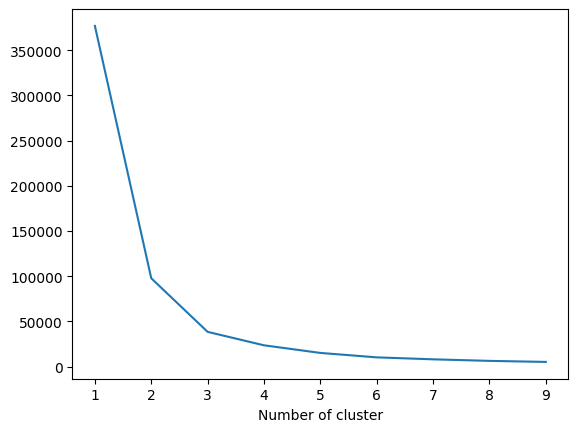

In [ ]:
from sklearn.cluster import KMeans
sse={}
tx_Recency = data[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_Recency)
    tx_Recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [ ]:
# Applying k-Means
kmeans=KMeans(n_clusters=4)
data['RecencyCluster']=kmeans.fit_predict(data[['Recency']])

#order the frequency cluster
data = order_cluster('RecencyCluster', 'Recency', data, False )
data.groupby('RecencyCluster')['Recency'].describe()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,233.0,76.261803,6.372390,65.25,70.500,76.00,80.75,89.75
1,146.0,54.102740,5.580189,45.00,49.750,53.75,58.00,65.00
2,139.0,35.442446,6.075261,24.50,30.500,36.25,41.00,44.75
3,119.0,13.224790,6.118826,1.75,8.625,13.25,17.75,24.25


In [ ]:
#get order counts for each user and create a dataframe with it
tx_frequency = df.groupby('GroupId').Invoicedate.count().reset_index()
tx_frequency.columns = ['GroupId','Frequency']
tx_frequency

,GroupId,Frequency
0,ERW_A1DS2023040002,7
1,ERW_A1DS2023040003,2
2,ERW_A1DS2023040005,27
3,ERW_A1T02022040001,1
4,ERW_A2JJ2023070001,12
...,...,...
632,ERW_DGVG2021110003,31
633,ERW_DJAK2021020001,1
634,ERW_DLD72021010006,3
635,ERW_DLD72021010008,12


In [ ]:
tx_frequency = tx_frequency.sort_values(by='Frequency', ascending=False)
tx_frequency

,GroupId,Frequency
71,ERW_AMBP2020110030,325
593,ERW_DBG72020110038,223
472,ERW_C08P2020090127,165
308,ERW_BM2U2020110053,165
382,ERW_BXEO2021030002,162
...,...,...
186,ERW_AMBP2020110503,1
53,ERW_AI8N2021070006,1
52,ERW_AI8N2021070003,1
548,ERW_CGAA2021010002,1


In [ ]:
# Divide the 'Frequency' column by 4
tx_frequency['Frequency'] = tx_frequency['Frequency'] / 4
tx_frequency

,GroupId,Frequency
71,ERW_AMBP2020110030,81.25
593,ERW_DBG72020110038,55.75
472,ERW_C08P2020090127,41.25
308,ERW_BM2U2020110053,41.25
382,ERW_BXEO2021030002,40.50
...,...,...
186,ERW_AMBP2020110503,0.25
53,ERW_AI8N2021070006,0.25
52,ERW_AI8N2021070003,0.25
548,ERW_CGAA2021010002,0.25


In [ ]:
data = pd.merge(data, tx_frequency, on='GroupId')
data

,GroupId,Recency,RecencyCluster,Frequency
0,ERW_AMBP2020110207,3.50,3,38.50
1,ERW_BM2U2020110053,6.50,3,41.25
2,ERW_C08P2020090096,13.00,3,5.25
3,ERW_BM2U2020110177,1.75,3,32.50
4,ERW_ADG22021040108,21.25,3,2.25
...,...,...,...,...
632,ERW_BM2U2020110001,84.25,0,0.25
633,ERW_BXEO2021030007,78.00,0,0.25
634,ERW_AMBP2020110732,73.75,0,0.25
635,ERW_C08P2020090018,76.75,0,0.75


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-367-9cd8d0324290>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tx_frequency["clusters"] = kmeans.labels_
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-367-9cd8d0324290>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

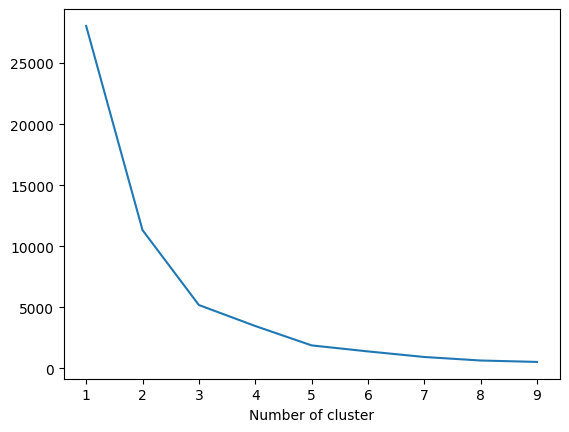

In [ ]:
from sklearn.cluster import KMeans

sse={}
tx_frequency = data[['Frequency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_frequency)
    tx_frequency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [ ]:
# Applying k-Means
kmeans=KMeans(n_clusters=4)
data['FrequencyCluster']=kmeans.fit_predict(data[['Frequency']])

#order the frequency cluster
data = order_cluster('FrequencyCluster', 'Frequency', data, True )
data.groupby('FrequencyCluster')['Frequency'].describe()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,475.0,1.298421,0.991138,0.25,0.50,1.000,2.0000,3.75
1,117.0,6.350427,1.974258,4.00,4.75,6.000,7.7500,11.00
2,36.0,16.493056,4.142328,11.50,13.25,15.375,18.5625,28.00
3,9.0,44.861111,15.119891,32.50,37.75,40.500,41.2500,81.25


In [ ]:
data

,GroupId,Recency,RecencyCluster,Frequency,FrequencyCluster
0,ERW_AMBP2020110207,3.50,3,38.50,3
1,ERW_BM2U2020110053,6.50,3,41.25,3
2,ERW_BM2U2020110177,1.75,3,32.50,3
3,ERW_DBG72020110038,4.00,3,55.75,3
4,ERW_AMBP2020110030,4.75,3,81.25,3
...,...,...,...,...,...
632,ERW_BM2U2020110077,9.75,3,24.50,2
633,ERW_BM2U2020110034,2.00,3,15.00,2
634,ERW_AMBP2020110060,7.25,3,23.75,2
635,ERW_AMBP2020110380,28.50,2,16.00,2


In [ ]:
df['Revenue'] = df['New_Volume(L)'] * df['Points']
tx_revenue = df.groupby('GroupId').Revenue.sum().reset_index()
tx_revenue

,GroupId,Revenue
0,ERW_A1DS2023040002,80524
1,ERW_A1DS2023040003,14840
2,ERW_A1DS2023040005,263228
3,ERW_A1T02022040001,18480
4,ERW_A2JJ2023070001,91950
...,...,...
632,ERW_DGVG2021110003,286710
633,ERW_DJAK2021020001,23632
634,ERW_DLD72021010006,60312
635,ERW_DLD72021010008,101740


In [ ]:
# Divide the 'Monetary' column by 4
tx_revenue['Revenue'] = tx_revenue['Revenue'] / 4
tx_revenue

,GroupId,Revenue
0,ERW_A1DS2023040002,20131.0
1,ERW_A1DS2023040003,3710.0
2,ERW_A1DS2023040005,65807.0
3,ERW_A1T02022040001,4620.0
4,ERW_A2JJ2023070001,22987.5
...,...,...
632,ERW_DGVG2021110003,71677.5
633,ERW_DJAK2021020001,5908.0
634,ERW_DLD72021010006,15078.0
635,ERW_DLD72021010008,25435.0


In [ ]:
#merge it with our main dataframe
data = pd.merge(data, tx_revenue, on='GroupId')
data

,GroupId,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue
0,ERW_AMBP2020110207,3.50,3,38.50,3,531042.50
1,ERW_BM2U2020110053,6.50,3,41.25,3,444759.50
2,ERW_BM2U2020110177,1.75,3,32.50,3,441099.50
3,ERW_DBG72020110038,4.00,3,55.75,3,547062.00
4,ERW_AMBP2020110030,4.75,3,81.25,3,1435159.75
...,...,...,...,...,...,...
632,ERW_BM2U2020110077,9.75,3,24.50,2,233879.50
633,ERW_BM2U2020110034,2.00,3,15.00,2,153920.00
634,ERW_AMBP2020110060,7.25,3,23.75,2,652398.00
635,ERW_AMBP2020110380,28.50,2,16.00,2,339575.00


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-373-57f5b7d8310b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tx_revenue["clusters"] = kmeans.labels_
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-373-57f5b7d8310b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

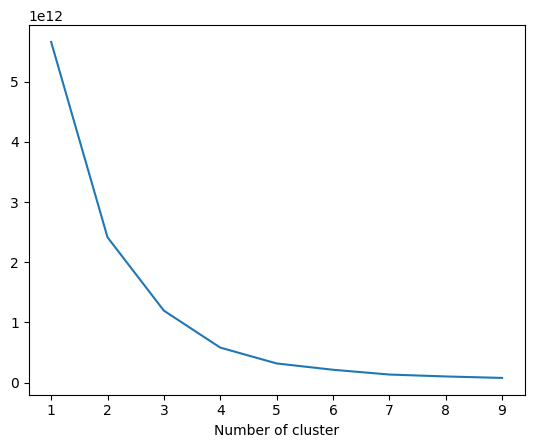

In [ ]:
sse={} # error
tx_revenue = data[['Revenue']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_revenue)
    tx_revenue["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [ ]:
#apply clustering
kmeans = KMeans(n_clusters=4)
data['RevenueCluster'] = kmeans.fit_predict(data[['Revenue']])

#order the cluster numbers
data = order_cluster('RevenueCluster', 'Revenue',data,True)

#show details of the dataframe
data.groupby('RevenueCluster')['Revenue'].describe()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,548.0,2.114281e+04,20089.918074,32.00,5767.00,13556.50,31493.250,79079.00
1,71.0,1.387108e+05,49127.989317,80940.00,99377.00,121725.00,176049.375,245975.50
2,17.0,4.057911e+05,109308.734155,273944.00,324051.50,378870.25,444759.500,652398.00
3,1.0,1.435160e+06,NaN,1435159.75,1435159.75,1435159.75,1435159.750,1435159.75


In [ ]:
data

,GroupId,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
0,ERW_AMBP2020110207,3.50,3,38.50,3,531042.5,2
1,ERW_BM2U2020110053,6.50,3,41.25,3,444759.5,2
2,ERW_BM2U2020110177,1.75,3,32.50,3,441099.5,2
3,ERW_DBG72020110038,4.00,3,55.75,3,547062.0,2
4,ERW_C08P2020090056,5.25,3,37.75,3,289682.5,2
...,...,...,...,...,...,...,...
632,ERW_BM2U2020110041,11.75,3,13.00,2,138123.0,1
633,ERW_BM2U2020110075,13.00,3,13.25,2,196019.0,1
634,ERW_BM2U2020110077,9.75,3,24.50,2,233879.5,1
635,ERW_BM2U2020110034,2.00,3,15.00,2,153920.0,1


In [ ]:
#calculate overall score and use mean() to see details
data['OverallScore'] = data['RecencyCluster'] + data['FrequencyCluster'] + data['RevenueCluster']
data.groupby('OverallScore')[['Recency','Frequency','Revenue']].mean()

,Recency,Frequency,Revenue
OverallScore,,,
0,76.283696,0.644565,8.339665e+03
1,54.635185,1.629630,1.892689e+04
2,38.275253,2.505051,2.809621e+04
3,29.445833,4.550000,5.392652e+04
4,19.232955,6.090909,7.708619e+04
5,15.700000,8.580000,1.332776e+05
6,12.925926,15.268519,1.688964e+05
7,8.406250,21.187500,4.054023e+05
8,3.937500,40.312500,4.144570e+05


In [ ]:
low_threshold = data['OverallScore'].quantile(0.33)
mid_threshold = data['OverallScore'].quantile(0.66)

print("Low threshold:", low_threshold)
print("Mid threshold:", mid_threshold)

Low threshold: 0.0
Mid threshold: 2.0


In [ ]:
data['Segment'] = 'Low-Value'
data.loc[data['OverallScore']>0,'Segment'] = 'Mid-Value'
data.loc[data['OverallScore']>2,'Segment'] = 'High-Value'

In [ ]:
data

,GroupId,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,ERW_AMBP2020110207,3.50,3,38.50,3,531042.5,2,8,High-Value
1,ERW_BM2U2020110053,6.50,3,41.25,3,444759.5,2,8,High-Value
2,ERW_BM2U2020110177,1.75,3,32.50,3,441099.5,2,8,High-Value
3,ERW_DBG72020110038,4.00,3,55.75,3,547062.0,2,8,High-Value
4,ERW_C08P2020090056,5.25,3,37.75,3,289682.5,2,8,High-Value
...,...,...,...,...,...,...,...,...,...
632,ERW_BM2U2020110041,11.75,3,13.00,2,138123.0,1,6,High-Value
633,ERW_BM2U2020110075,13.00,3,13.25,2,196019.0,1,6,High-Value
634,ERW_BM2U2020110077,9.75,3,24.50,2,233879.5,1,6,High-Value
635,ERW_BM2U2020110034,2.00,3,15.00,2,153920.0,1,6,High-Value


#TRY K mean to get Cluster (Target)

In [ ]:
data.to_csv('Data.csv', index=False)

from google.colab import files
files.download('Data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

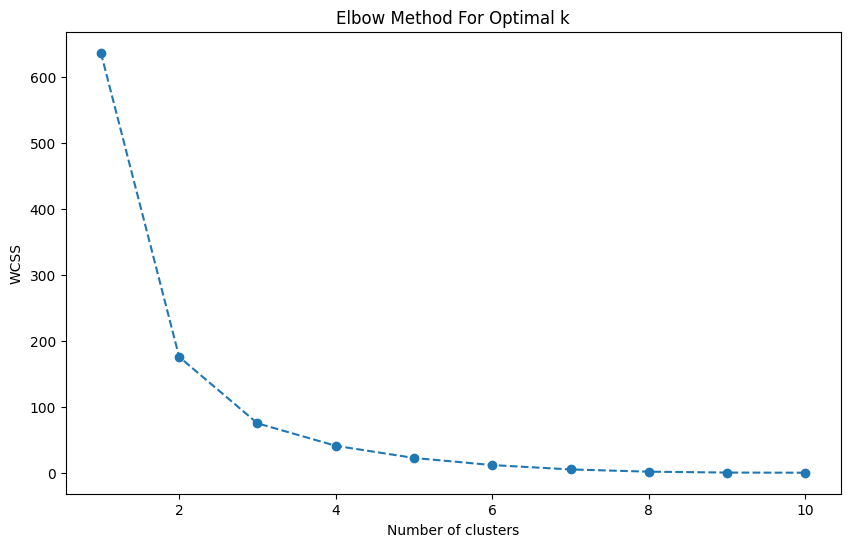

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Extract the OverallScore column
Overall = data[['OverallScore']]

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(Overall)

# Determine the optimal number of clusters using the elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot the elbow method graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')  # Within-cluster sum of squares
plt.show()

In [ ]:
# Let's assume the optimal number of clusters is 3 based on the elbow plot
kmeans = KMeans(n_clusters=3, random_state=0)
clusters = kmeans.fit_predict(X_scaled)

# Add the cluster labels to the original DataFrame
data['Cluster'] = clusters

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
data

,GroupId,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,Cluster
0,ERW_AMBP2020110207,3.50,3,38.50,3,531042.5,2,8,High-Value,2
1,ERW_BM2U2020110053,6.50,3,41.25,3,444759.5,2,8,High-Value,2
2,ERW_BM2U2020110177,1.75,3,32.50,3,441099.5,2,8,High-Value,2
3,ERW_DBG72020110038,4.00,3,55.75,3,547062.0,2,8,High-Value,2
4,ERW_C08P2020090056,5.25,3,37.75,3,289682.5,2,8,High-Value,2
...,...,...,...,...,...,...,...,...,...,...
632,ERW_BM2U2020110041,11.75,3,13.00,2,138123.0,1,6,High-Value,2
633,ERW_BM2U2020110075,13.00,3,13.25,2,196019.0,1,6,High-Value,2
634,ERW_BM2U2020110077,9.75,3,24.50,2,233879.5,1,6,High-Value,2
635,ERW_BM2U2020110034,2.00,3,15.00,2,153920.0,1,6,High-Value,2


In [ ]:
mid = data[(data['OverallScore'] > 1) & (data['OverallScore'] < 5)]
print(mid.count())

high = data[(data['OverallScore'] > 4)]
high.count()

low = data[(data['OverallScore'] < 2)]
low.count()

#cluster 0 - mid: count = 203
#cluster 2 - high: count = 69
#cluster 1 - low: count = 365

Recency             203
RecencyCluster      203
Frequency           203
FrequencyCluster    203
Revenue             203
RevenueCluster      203
OverallScore        203
Segment             203
Cluster             203
MappedCluster       203
dtype: int64


Recency             365
RecencyCluster      365
Frequency           365
FrequencyCluster    365
Revenue             365
RevenueCluster      365
OverallScore        365
Segment             365
Cluster             365
MappedCluster       365
dtype: int64

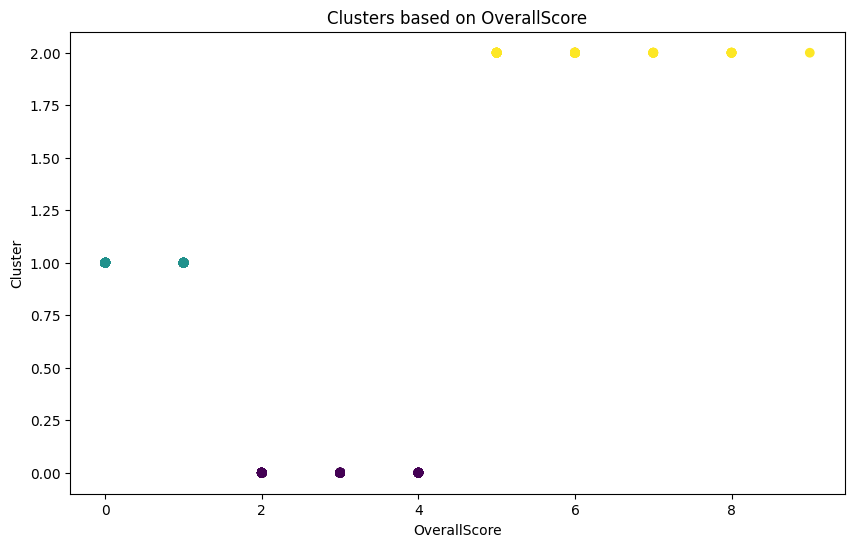

In [ ]:
# Visualize the clusters
plt.figure(figsize=(10, 6))
plt.scatter(data['OverallScore'], data['Cluster'], c=clusters, cmap='viridis')
plt.title('Clusters based on OverallScore')
plt.xlabel('OverallScore')
plt.ylabel('Cluster')
plt.show()

#Visualize Cluster

<ipython-input-437-3b1041ebbced>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')


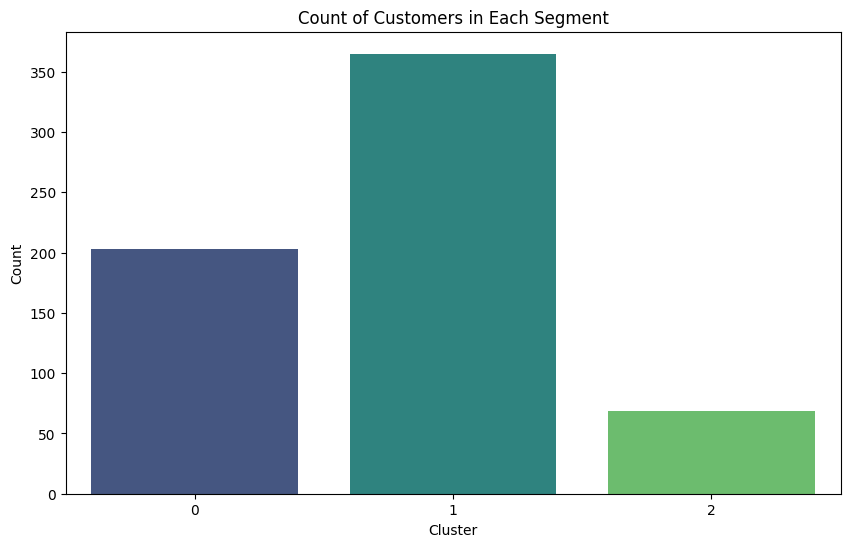

<ipython-input-437-3b1041ebbced>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_mean_scores['Cluster'], y=cluster_mean_scores['OverallScore'], palette='viridis')


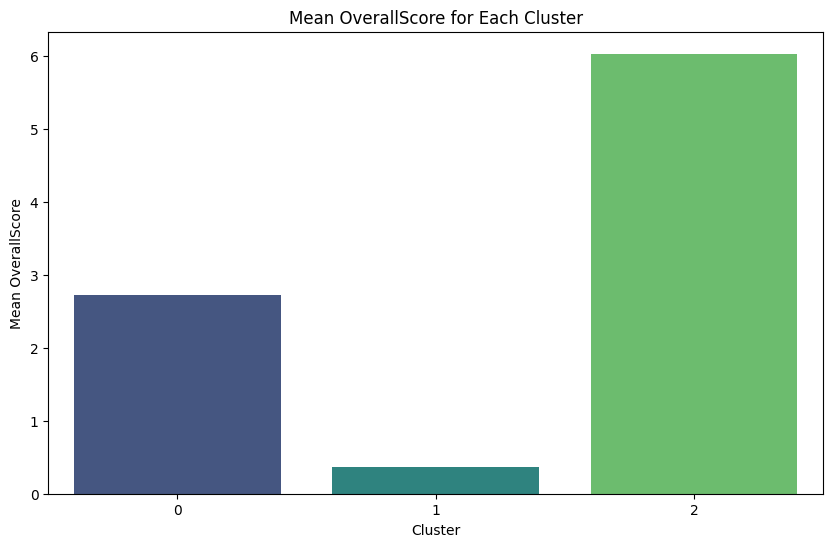

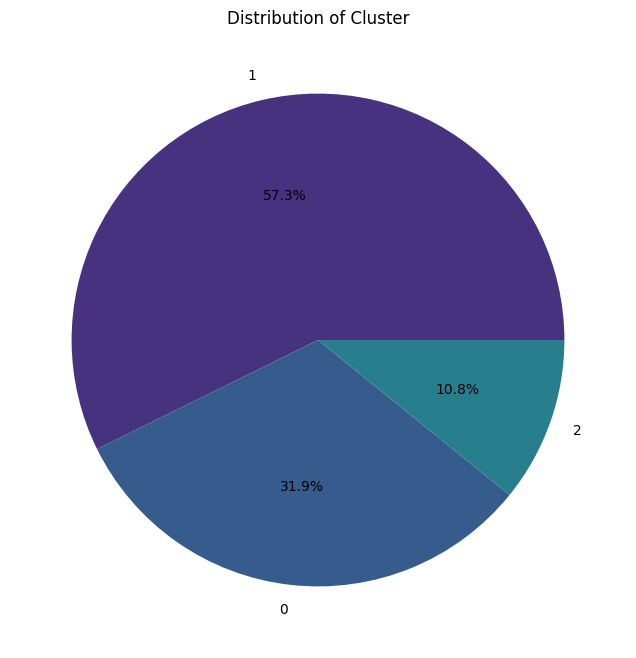

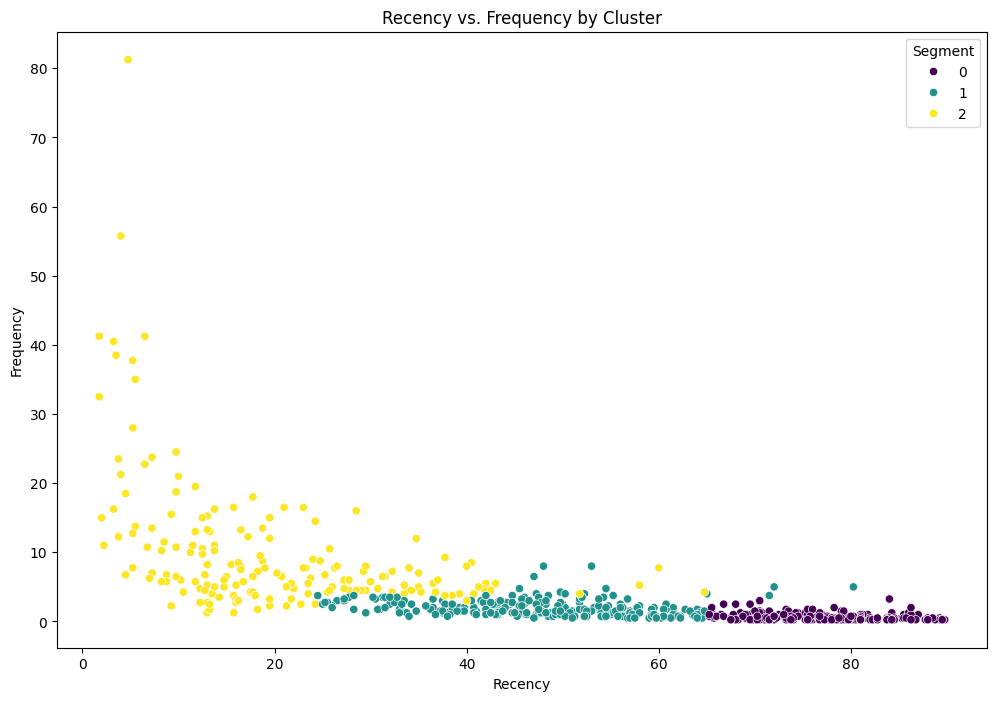

<ipython-input-437-3b1041ebbced>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='Cluster', y='Recency', palette='viridis')


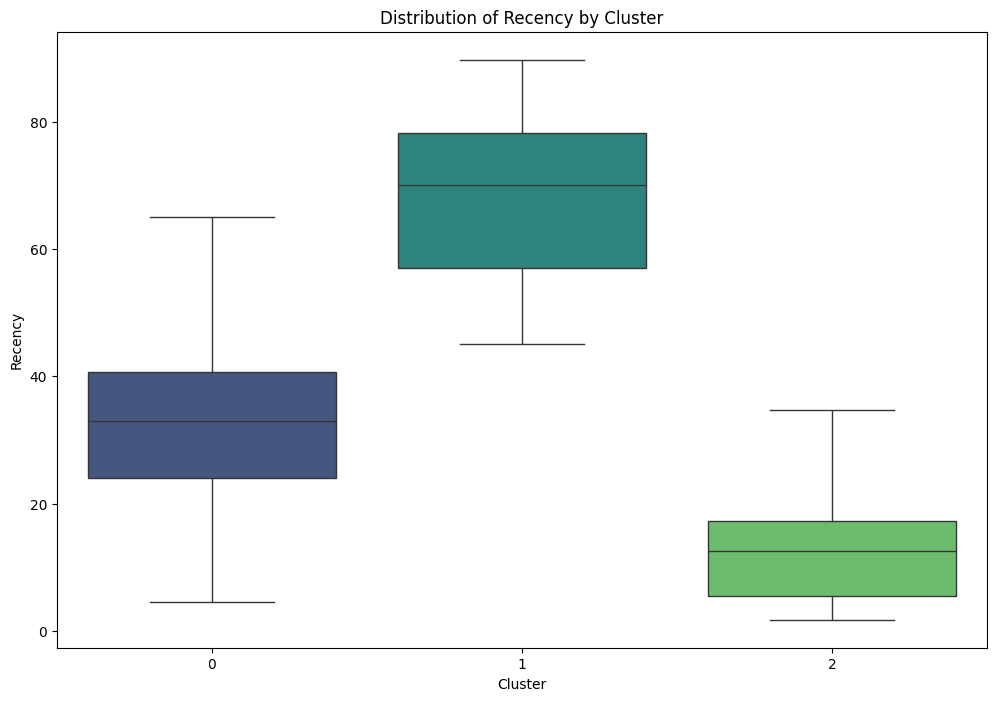

In [ ]:
# 1. Bar Chart
cluster_counts = data['Cluster'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')
plt.title('Count of Customers in Each Segment')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

#1.1
cluster_mean_scores = data.groupby('Cluster')['OverallScore'].mean().reset_index()
# Plotting the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_mean_scores['Cluster'], y=cluster_mean_scores['OverallScore'], palette='viridis')
plt.title('Mean OverallScore for Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Mean OverallScore')
plt.show()

# 2. Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%', colors=sns.color_palette('viridis'))
plt.title('Distribution of Cluster')
plt.show()

# 3. Scatter Plot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=data, x='Recency', y='Frequency', hue='Segment', palette='viridis')
plt.title('Recency vs. Frequency by Cluster')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.show()

# 4. Box Plot
plt.figure(figsize=(12, 8))
sns.boxplot(data=data, x='Cluster', y='Recency', palette='viridis')
plt.title('Distribution of Recency by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Recency')
plt.show()

#Download CSV for Analytic

In [ ]:
df

,Invoicedate,Distributor,GroupId,Type,Provincename,MatNo,Material Name,New_Volume(L),Points,Revenue
0,2023-09-06,A,ERW_AMBP2020110207,Reseller,Chachoengsao,145577,M SUP Frict Fighter TBS 10W-30 4x7L/CAR,11676,2,23352
1,2023-12-20,A,ERW_AMBP2020110207,Reseller,Chachoengsao,145577,M SUP Frict Fighter TBS 10W-30 4x7L/CAR,5768,2,11536
2,2023-08-11,A,ERW_AMBP2020110207,Reseller,Chachoengsao,143160,MOBIL DELVAC SUPER1400 15W-40 4X6+1L/CAR,11088,2,22176
3,2023-03-10,A,ERW_AMBP2020110291,Reseller,Nakhon Ratchasima,143160,MOBIL DELVAC SUPER 1400 15W-40 4X6+1/CAR,2912,2,5824
4,2023-03-10,A,ERW_AMBP2020110291,Reseller,Nakhon Ratchasima,143160,MOBIL DELVAC SUPER1400 15W-40 4X6+1L/CAR,7168,2,14336
...,...,...,...,...,...,...,...,...,...,...
9424,2023-03-11,C,ERW_C08P2020090135,Retails,Lampang,140417,"MOBIL 1 TURBO DIESEL 5W-40, 12X1LT CTN",281,10,2810
9425,2023-07-18,C,ERW_C08P2020090145,Retails,Chiang Mai,140417,"MOBIL 1 TURBO DIESEL 5W-40, 12X1LT CTN",354,10,3540
9426,2023-10-19,C,ERW_C08P2020090203,Retails,Chiang Mai,140635,"MOBIL 1 FS X2 5W50, 12X1L CTN",281,10,2810
9427,2023-11-29,C,ERW_C08P2020090203,Retails,Chiang Mai,140635,"MOBIL 1 FS X2 5W50, 12X1L CTN",162,10,1620


In [ ]:
data

,GroupId,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,Cluster
0,ERW_AMBP2020110207,3.50,3,38.50,3,531042.5,2,8,High-Value,2
1,ERW_BM2U2020110053,6.50,3,41.25,3,444759.5,2,8,High-Value,2
2,ERW_BM2U2020110177,1.75,3,32.50,3,441099.5,2,8,High-Value,2
3,ERW_DBG72020110038,4.00,3,55.75,3,547062.0,2,8,High-Value,2
4,ERW_C08P2020090056,5.25,3,37.75,3,289682.5,2,8,High-Value,2
...,...,...,...,...,...,...,...,...,...,...
632,ERW_BM2U2020110041,11.75,3,13.00,2,138123.0,1,6,High-Value,2
633,ERW_BM2U2020110075,13.00,3,13.25,2,196019.0,1,6,High-Value,2
634,ERW_BM2U2020110077,9.75,3,24.50,2,233879.5,1,6,High-Value,2
635,ERW_BM2U2020110034,2.00,3,15.00,2,153920.0,1,6,High-Value,2


In [ ]:
# Perform the merge on the 'GroupId' column
AnalyticData = data.merge(df[['GroupId', 'Provincename','Distributor']], on='GroupId', how='left')
AnalyticData

,GroupId,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,Cluster,Provincename,Distributor
0,ERW_AMBP2020110207,3.50,3,38.5,3,531042.5,2,8,High-Value,2,Chachoengsao,A
1,ERW_AMBP2020110207,3.50,3,38.5,3,531042.5,2,8,High-Value,2,Chachoengsao,A
2,ERW_AMBP2020110207,3.50,3,38.5,3,531042.5,2,8,High-Value,2,Chachoengsao,A
3,ERW_AMBP2020110207,3.50,3,38.5,3,531042.5,2,8,High-Value,2,Chachoengsao,A
4,ERW_AMBP2020110207,3.50,3,38.5,3,531042.5,2,8,High-Value,2,Chachoengsao,A
...,...,...,...,...,...,...,...,...,...,...,...,...
9424,ERW_AUOF2022100001,34.75,2,12.0,2,228703.5,1,5,High-Value,2,Bangkok,A
9425,ERW_AUOF2022100001,34.75,2,12.0,2,228703.5,1,5,High-Value,2,Bangkok,A
9426,ERW_AUOF2022100001,34.75,2,12.0,2,228703.5,1,5,High-Value,2,Bangkok,A
9427,ERW_AUOF2022100001,34.75,2,12.0,2,228703.5,1,5,High-Value,2,Bangkok,A


In [ ]:
grouped_data = AnalyticData.drop_duplicates(subset='GroupId')
grouped_data

,GroupId,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,Cluster,Provincename,Distributor
0,ERW_AMBP2020110207,3.50,3,38.50,3,531042.5,2,8,High-Value,2,Chachoengsao,A
154,ERW_BM2U2020110053,6.50,3,41.25,3,444759.5,2,8,High-Value,2,Nakhon Pathom,B
319,ERW_BM2U2020110177,1.75,3,32.50,3,441099.5,2,8,High-Value,2,Nakhon Pathom,B
449,ERW_DBG72020110038,4.00,3,55.75,3,547062.0,2,8,High-Value,2,Phuket,D
672,ERW_C08P2020090056,5.25,3,37.75,3,289682.5,2,8,High-Value,2,Nakhon Sawan,C
...,...,...,...,...,...,...,...,...,...,...,...,...
9118,ERW_BM2U2020110041,11.75,3,13.00,2,138123.0,1,6,High-Value,2,Nakhon Pathom,B
9170,ERW_BM2U2020110075,13.00,3,13.25,2,196019.0,1,6,High-Value,2,Bangkok,B
9223,ERW_BM2U2020110077,9.75,3,24.50,2,233879.5,1,6,High-Value,2,Samut Sakhon,B
9321,ERW_BM2U2020110034,2.00,3,15.00,2,153920.0,1,6,High-Value,2,Nakhon Pathom,B


In [ ]:
grouped_data.to_csv('Retail CLV Analysis.csv', index=False)

from google.colab import files
files.download('Retail CLV Analysis.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Visualization

In [ ]:
high_count = data[data['Segment'] == 'Mid-Value'].shape[0]
high_count

234

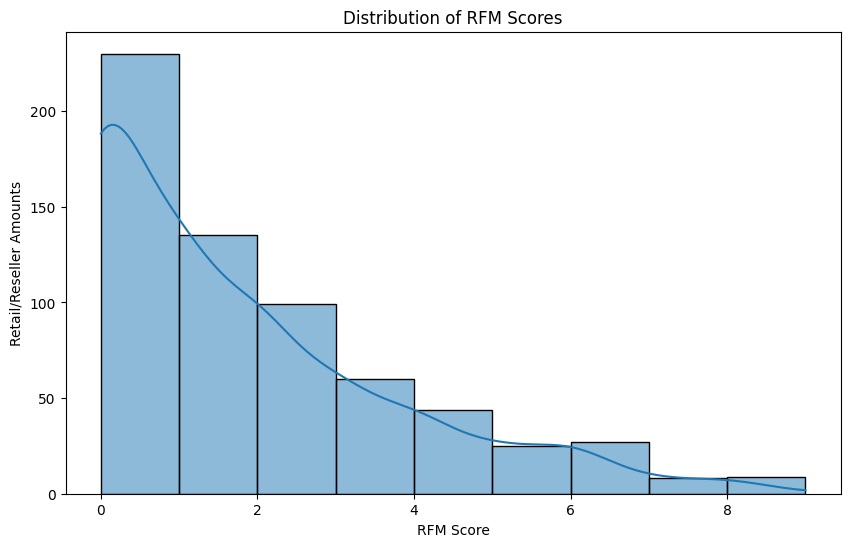

In [ ]:
import seaborn as sns

# Assuming rfm_scores is your DataFrame
plt.figure(figsize=(10, 6))
sns.histplot(data['OverallScore'], bins=9, kde=True)
plt.title('Distribution of RFM Scores')
plt.xlabel('RFM Score')
plt.ylabel('Retail/Reseller Amounts')
plt.show()

<ipython-input-392-65cd337117fa>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='viridis')


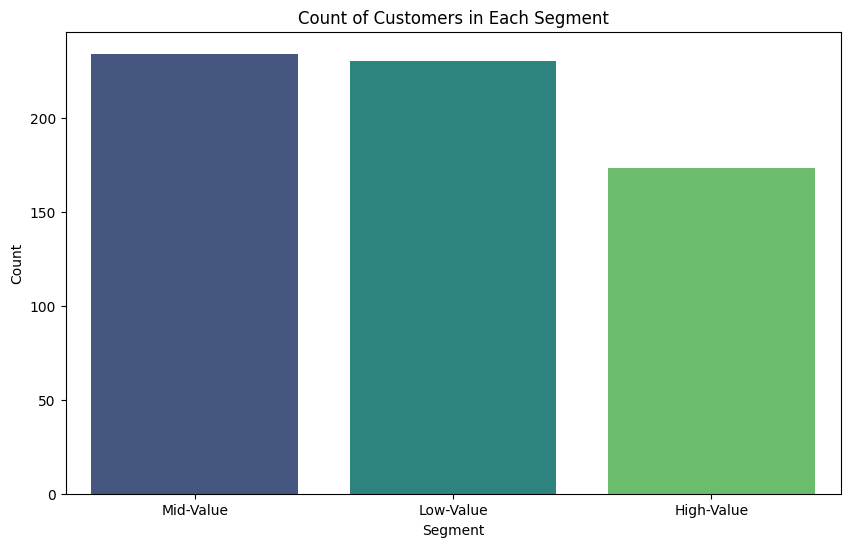

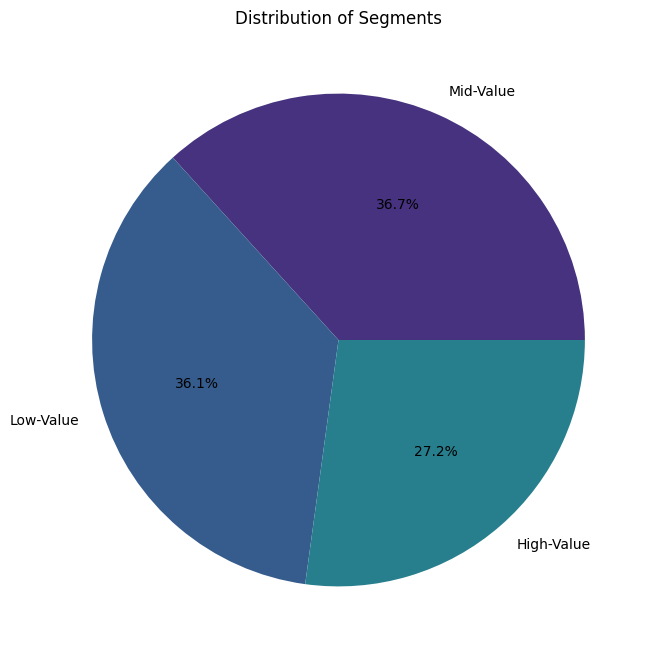

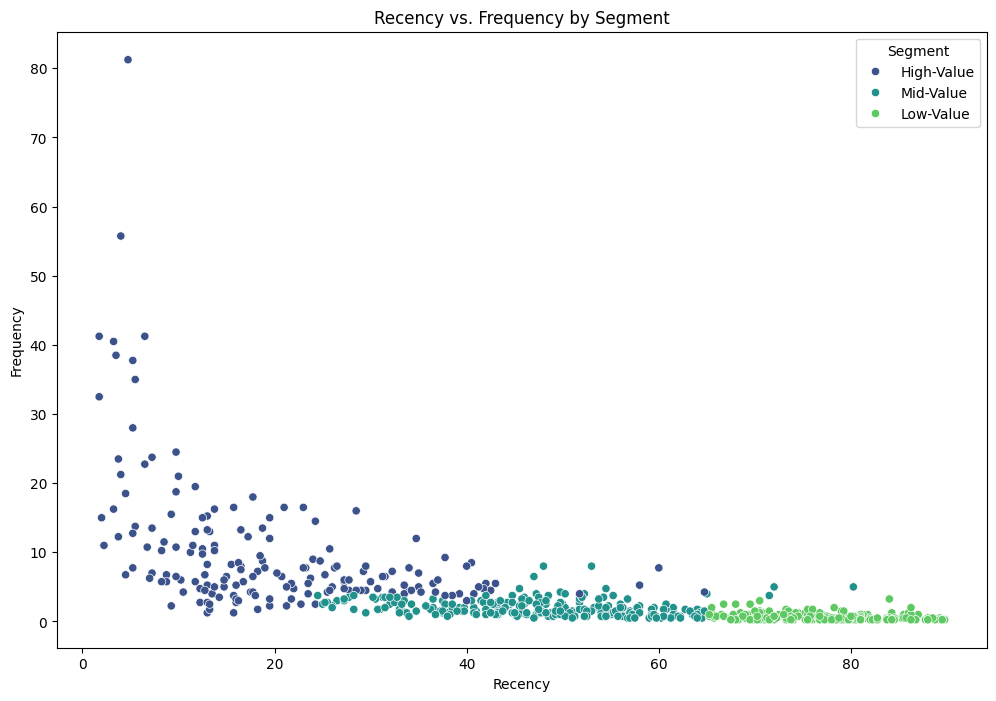

<ipython-input-392-65cd337117fa>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='Segment', y='Recency', palette='viridis')


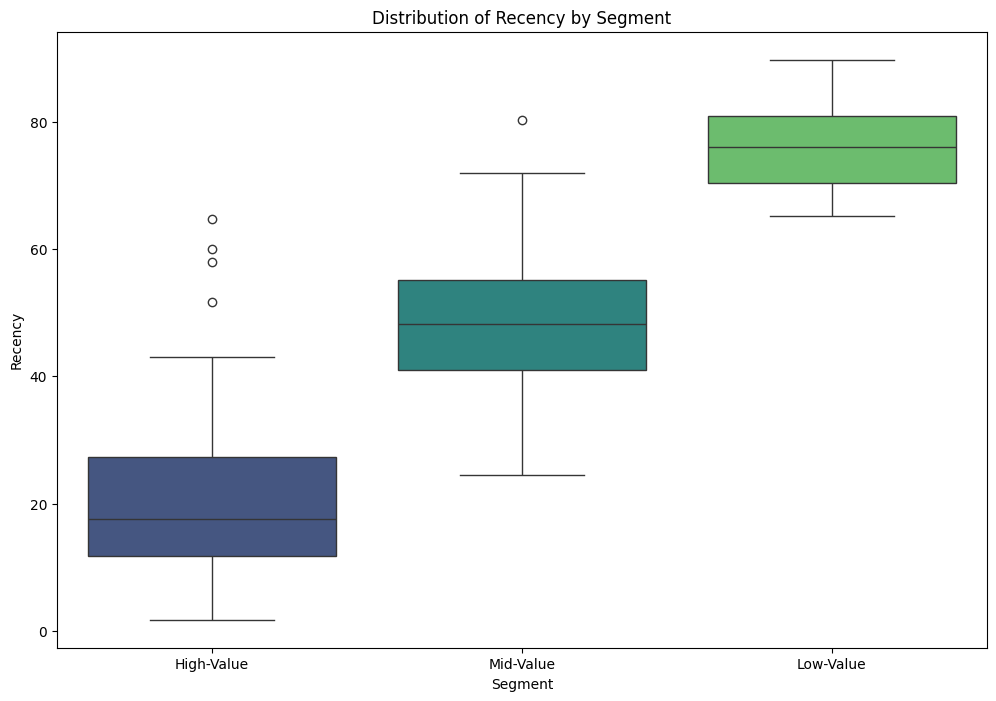

In [ ]:
import seaborn as sns

# 1. Bar Chart
segment_counts = data['Segment'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='viridis')
plt.title('Count of Customers in Each Segment')
plt.xlabel('Segment')
plt.ylabel('Count')
plt.show()

# 2. Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', colors=sns.color_palette('viridis'))
plt.title('Distribution of Segments')
plt.show()

# 3. Scatter Plot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=data, x='Recency', y='Frequency', hue='Segment', palette='viridis')
plt.title('Recency vs. Frequency by Segment')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.show()

# 4. Box Plot
plt.figure(figsize=(12, 8))
sns.boxplot(data=data, x='Segment', y='Recency', palette='viridis')
plt.title('Distribution of Recency by Segment')
plt.xlabel('Segment')
plt.ylabel('Recency')
plt.show()

In [ ]:
segment_mapping = {"High-Value": 2, "Mid-Value": 1, "Low-Value": 0}

data["Segment"] = data["Segment"].map(segment_mapping)

In [ ]:
data

,GroupId,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,Cluster
0,ERW_AMBP2020110207,3.50,3,38.50,3,531042.5,2,8,2,2
1,ERW_BM2U2020110053,6.50,3,41.25,3,444759.5,2,8,2,2
2,ERW_BM2U2020110177,1.75,3,32.50,3,441099.5,2,8,2,2
3,ERW_DBG72020110038,4.00,3,55.75,3,547062.0,2,8,2,2
4,ERW_C08P2020090056,5.25,3,37.75,3,289682.5,2,8,2,2
...,...,...,...,...,...,...,...,...,...,...
632,ERW_BM2U2020110041,11.75,3,13.00,2,138123.0,1,6,2,2
633,ERW_BM2U2020110075,13.00,3,13.25,2,196019.0,1,6,2,2
634,ERW_BM2U2020110077,9.75,3,24.50,2,233879.5,1,6,2,2
635,ERW_BM2U2020110034,2.00,3,15.00,2,153920.0,1,6,2,2


In [ ]:
# Check if Segment and Cluster columns are the same
comparison = data['Segment'] == data['Cluster']

# Display the rows where they are different
mismatched_rows = data[~comparison]

# Show mismatched rows if any
mismatched_rows

,GroupId,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,Cluster
18,ERW_C08P2020090096,13.00,3,5.25,1,49549.0,0,4,2,0
19,ERW_A1DS2023040005,8.75,3,6.75,1,65807.0,0,4,2,0
20,ERW_AJ0E2020120005,4.50,3,6.75,1,75268.5,0,4,2,0
21,ERW_DGVG2021110003,5.25,3,7.75,1,71677.5,0,4,2,0
22,ERW_C08P2020090041,13.50,3,4.00,1,44857.0,0,4,2,0
...,...,...,...,...,...,...,...,...,...,...
604,ERW_BM2U2020110072,60.00,1,7.75,1,91506.0,1,3,2,0
605,ERW_B5CM2020120006,51.75,1,4.00,1,97716.0,1,3,2,0
606,ERW_CM8N2021050004,40.00,2,3.00,0,80940.0,1,3,2,0
607,ERW_AMBP2020110605,38.50,2,3.75,0,113562.5,1,3,2,0


In [ ]:
data.value_counts('Cluster')

Cluster
1    365
0    203
2     69
Name: count, dtype: int64

In [ ]:
# Create a new column 'MappedSegment' based on the Cluster column with the specified mapping
mapping = {1: 'Low-Value', 0: 'Mid-Value', 2: 'High-Value'}
data['MappedCluster'] = data['Cluster'].map(mapping)

#cluster 0 - mid: count = 203
#cluster 2 - high: count = 69
#cluster 1 - low: count = 365

In [ ]:
data

,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,Cluster,MappedCluster
GroupId,,,,,,,,,,
ERW_AMBP2020110207,3.50,3,38.50,3,531042.5,2,8,2,2,High-Value
ERW_BM2U2020110053,6.50,3,41.25,3,444759.5,2,8,2,2,High-Value
ERW_BM2U2020110177,1.75,3,32.50,3,441099.5,2,8,2,2,High-Value
ERW_DBG72020110038,4.00,3,55.75,3,547062.0,2,8,2,2,High-Value
ERW_C08P2020090056,5.25,3,37.75,3,289682.5,2,8,2,2,High-Value
...,...,...,...,...,...,...,...,...,...,...
ERW_BM2U2020110041,11.75,3,13.00,2,138123.0,1,6,2,2,High-Value
ERW_BM2U2020110075,13.00,3,13.25,2,196019.0,1,6,2,2,High-Value
ERW_BM2U2020110077,9.75,3,24.50,2,233879.5,1,6,2,2,High-Value


#Update Visual

In [ ]:
data

,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,Cluster,MappedCluster
GroupId,,,,,,,,,,
ERW_AMBP2020110207,3.50,3,38.50,3,531042.5,2,8,2,2,High-Value
ERW_BM2U2020110053,6.50,3,41.25,3,444759.5,2,8,2,2,High-Value
ERW_BM2U2020110177,1.75,3,32.50,3,441099.5,2,8,2,2,High-Value
ERW_DBG72020110038,4.00,3,55.75,3,547062.0,2,8,2,2,High-Value
ERW_C08P2020090056,5.25,3,37.75,3,289682.5,2,8,2,2,High-Value
...,...,...,...,...,...,...,...,...,...,...
ERW_BM2U2020110041,11.75,3,13.00,2,138123.0,1,6,2,2,High-Value
ERW_BM2U2020110075,13.00,3,13.25,2,196019.0,1,6,2,2,High-Value
ERW_BM2U2020110077,9.75,3,24.50,2,233879.5,1,6,2,2,High-Value


In [ ]:
datavisual = data.reset_index()
datavisual

,GroupId,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,Cluster,MappedCluster
0,ERW_AMBP2020110207,3.50,3,38.50,3,531042.5,2,8,2,2,High-Value
1,ERW_BM2U2020110053,6.50,3,41.25,3,444759.5,2,8,2,2,High-Value
2,ERW_BM2U2020110177,1.75,3,32.50,3,441099.5,2,8,2,2,High-Value
3,ERW_DBG72020110038,4.00,3,55.75,3,547062.0,2,8,2,2,High-Value
4,ERW_C08P2020090056,5.25,3,37.75,3,289682.5,2,8,2,2,High-Value
...,...,...,...,...,...,...,...,...,...,...,...
632,ERW_BM2U2020110041,11.75,3,13.00,2,138123.0,1,6,2,2,High-Value
633,ERW_BM2U2020110075,13.00,3,13.25,2,196019.0,1,6,2,2,High-Value
634,ERW_BM2U2020110077,9.75,3,24.50,2,233879.5,1,6,2,2,High-Value
635,ERW_BM2U2020110034,2.00,3,15.00,2,153920.0,1,6,2,2,High-Value


In [ ]:
df

,Invoicedate,Distributor,GroupId,Type,Provincename,MatNo,Material Name,New_Volume(L),Points,Revenue
0,2023-09-06,A,ERW_AMBP2020110207,Reseller,Chachoengsao,145577,M SUP Frict Fighter TBS 10W-30 4x7L/CAR,11676,2,23352
1,2023-12-20,A,ERW_AMBP2020110207,Reseller,Chachoengsao,145577,M SUP Frict Fighter TBS 10W-30 4x7L/CAR,5768,2,11536
2,2023-08-11,A,ERW_AMBP2020110207,Reseller,Chachoengsao,143160,MOBIL DELVAC SUPER1400 15W-40 4X6+1L/CAR,11088,2,22176
3,2023-03-10,A,ERW_AMBP2020110291,Reseller,Nakhon Ratchasima,143160,MOBIL DELVAC SUPER 1400 15W-40 4X6+1/CAR,2912,2,5824
4,2023-03-10,A,ERW_AMBP2020110291,Reseller,Nakhon Ratchasima,143160,MOBIL DELVAC SUPER1400 15W-40 4X6+1L/CAR,7168,2,14336
...,...,...,...,...,...,...,...,...,...,...
9424,2023-03-11,C,ERW_C08P2020090135,Retails,Lampang,140417,"MOBIL 1 TURBO DIESEL 5W-40, 12X1LT CTN",281,10,2810
9425,2023-07-18,C,ERW_C08P2020090145,Retails,Chiang Mai,140417,"MOBIL 1 TURBO DIESEL 5W-40, 12X1LT CTN",354,10,3540
9426,2023-10-19,C,ERW_C08P2020090203,Retails,Chiang Mai,140635,"MOBIL 1 FS X2 5W50, 12X1L CTN",281,10,2810
9427,2023-11-29,C,ERW_C08P2020090203,Retails,Chiang Mai,140635,"MOBIL 1 FS X2 5W50, 12X1L CTN",162,10,1620


In [ ]:
# Perform the merge on the 'GroupId' column
UpdateData = datavisual.merge(df[['GroupId', 'Provincename','Distributor']], on='GroupId', how='left')
UpdateData

,GroupId,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,Cluster,MappedCluster,Provincename,Distributor
0,ERW_AMBP2020110207,3.50,3,38.5,3,531042.5,2,8,2,2,High-Value,Chachoengsao,A
1,ERW_AMBP2020110207,3.50,3,38.5,3,531042.5,2,8,2,2,High-Value,Chachoengsao,A
2,ERW_AMBP2020110207,3.50,3,38.5,3,531042.5,2,8,2,2,High-Value,Chachoengsao,A
3,ERW_AMBP2020110207,3.50,3,38.5,3,531042.5,2,8,2,2,High-Value,Chachoengsao,A
4,ERW_AMBP2020110207,3.50,3,38.5,3,531042.5,2,8,2,2,High-Value,Chachoengsao,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9424,ERW_AUOF2022100001,34.75,2,12.0,2,228703.5,1,5,2,2,High-Value,Bangkok,A
9425,ERW_AUOF2022100001,34.75,2,12.0,2,228703.5,1,5,2,2,High-Value,Bangkok,A
9426,ERW_AUOF2022100001,34.75,2,12.0,2,228703.5,1,5,2,2,High-Value,Bangkok,A
9427,ERW_AUOF2022100001,34.75,2,12.0,2,228703.5,1,5,2,2,High-Value,Bangkok,A


In [ ]:
Updategrouped_data = UpdateData.drop_duplicates(subset='GroupId')
Updategrouped_data

,GroupId,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,Cluster,MappedCluster,Provincename,Distributor
0,ERW_AMBP2020110207,3.50,3,38.50,3,531042.5,2,8,2,2,High-Value,Chachoengsao,A
154,ERW_BM2U2020110053,6.50,3,41.25,3,444759.5,2,8,2,2,High-Value,Nakhon Pathom,B
319,ERW_BM2U2020110177,1.75,3,32.50,3,441099.5,2,8,2,2,High-Value,Nakhon Pathom,B
449,ERW_DBG72020110038,4.00,3,55.75,3,547062.0,2,8,2,2,High-Value,Phuket,D
672,ERW_C08P2020090056,5.25,3,37.75,3,289682.5,2,8,2,2,High-Value,Nakhon Sawan,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9118,ERW_BM2U2020110041,11.75,3,13.00,2,138123.0,1,6,2,2,High-Value,Nakhon Pathom,B
9170,ERW_BM2U2020110075,13.00,3,13.25,2,196019.0,1,6,2,2,High-Value,Bangkok,B
9223,ERW_BM2U2020110077,9.75,3,24.50,2,233879.5,1,6,2,2,High-Value,Samut Sakhon,B
9321,ERW_BM2U2020110034,2.00,3,15.00,2,153920.0,1,6,2,2,High-Value,Nakhon Pathom,B


In [ ]:
Updategrouped_data.to_csv('Update Retail CLV Analysis.csv', index=False)

from google.colab import files
files.download('Update Retail CLV Analysis.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
high_count = data[data['MappedCluster'] == 'High-Value'].shape[0]
print(high_count)

mid_count = data[data['MappedCluster'] == 'Mid-Value'].shape[0]
print(mid_count)

low_count = data[data['MappedCluster'] == 'Low-Value'].shape[0]
print(low_count)

69
203
365


#Visualize Cluster

<ipython-input-443-a73e66a3728e>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')


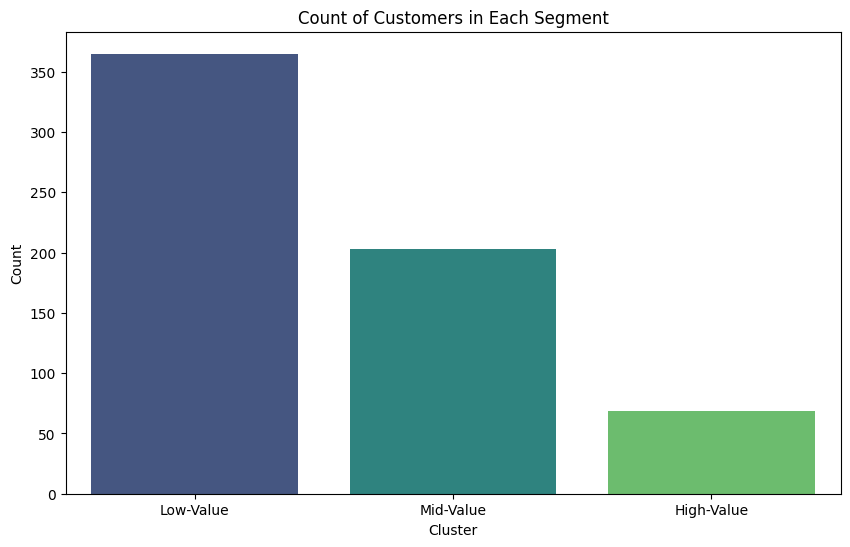

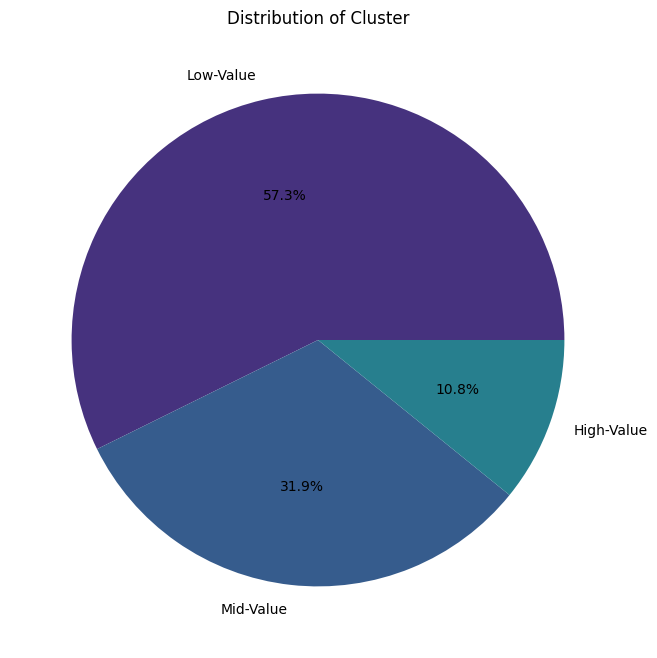

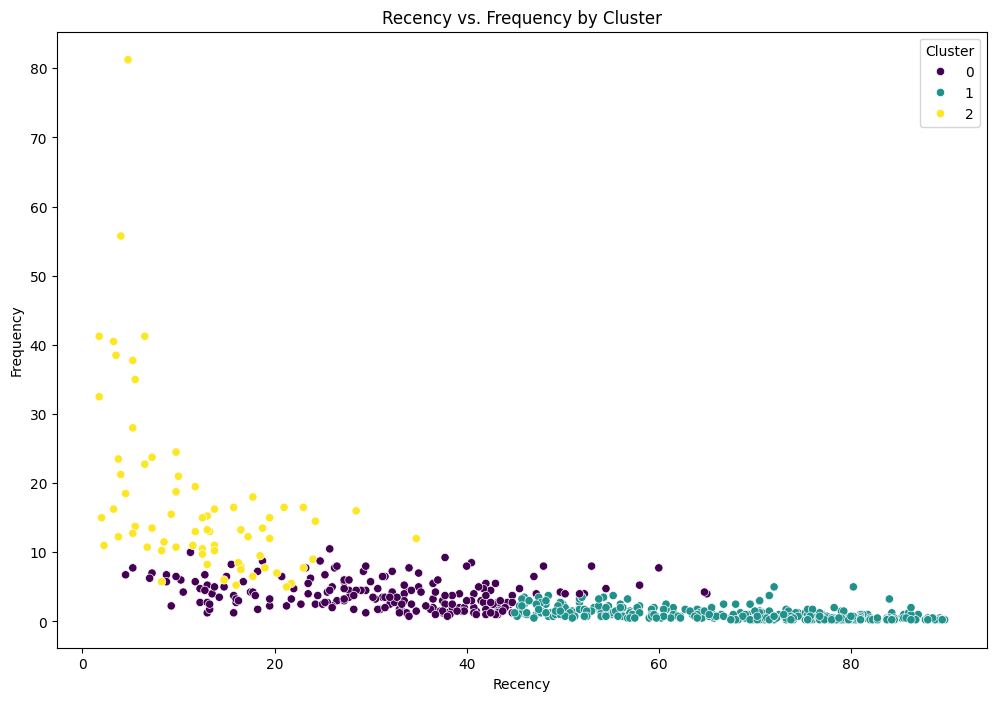

<ipython-input-443-a73e66a3728e>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='Cluster', y='Recency', palette='viridis')


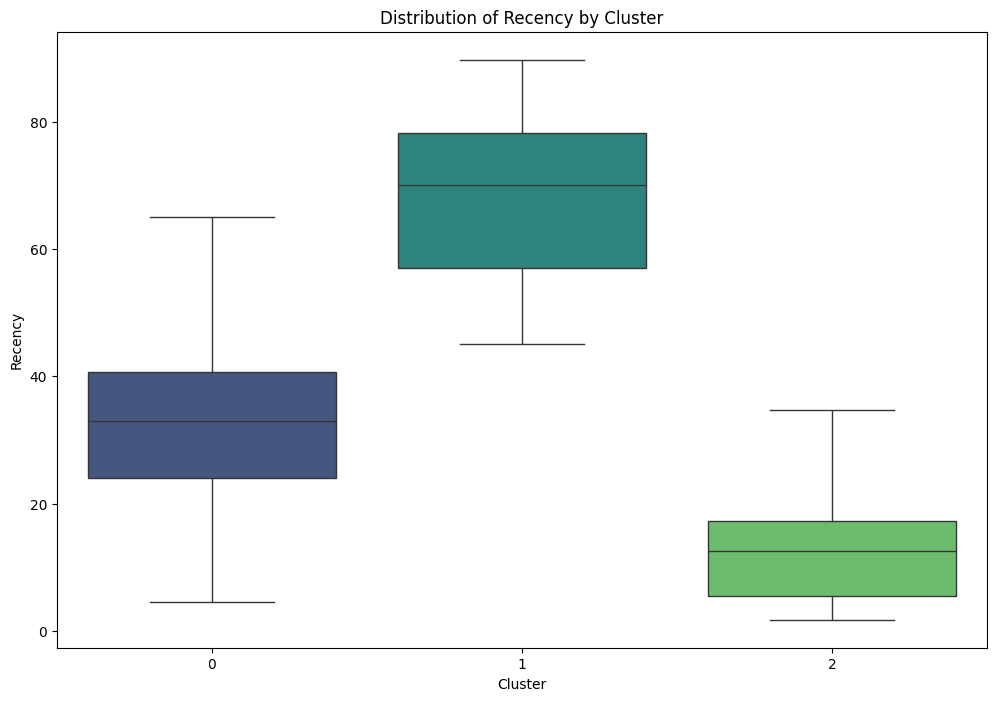

In [ ]:
# 1. Bar Chart
cluster_counts = data['MappedCluster'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')
plt.title('Count of Customers in Each Segment')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

# 2. Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%', colors=sns.color_palette('viridis'))
plt.title('Distribution of Cluster')
plt.show()

# 3. Scatter Plot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=data, x='Recency', y='Frequency', hue='Cluster', palette='viridis')
plt.title('Recency vs. Frequency by Cluster')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.show()

# 4. Box Plot
plt.figure(figsize=(12, 8))
sns.boxplot(data=data, x='Cluster', y='Recency', palette='viridis')
plt.title('Distribution of Recency by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Recency')
plt.show()

#cluster 0 - mid: count = 203
#cluster 2 - high: count = 69
#cluster 1 - low: count = 365

In [ ]:
data.value_counts('Segment')

Segment
1    234
0    230
2    173
Name: count, dtype: int64

In [ ]:
data.set_index('GroupId', inplace=True)

KeyError: "None of ['GroupId'] are in the columns"

In [ ]:
data

,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,Cluster,MappedCluster
GroupId,,,,,,,,,,
ERW_AMBP2020110207,3.50,3,38.50,3,531042.5,2,8,2,2,High-Value
ERW_BM2U2020110053,6.50,3,41.25,3,444759.5,2,8,2,2,High-Value
ERW_BM2U2020110177,1.75,3,32.50,3,441099.5,2,8,2,2,High-Value
ERW_DBG72020110038,4.00,3,55.75,3,547062.0,2,8,2,2,High-Value
ERW_C08P2020090056,5.25,3,37.75,3,289682.5,2,8,2,2,High-Value
...,...,...,...,...,...,...,...,...,...,...
ERW_BM2U2020110041,11.75,3,13.00,2,138123.0,1,6,2,2,High-Value
ERW_BM2U2020110075,13.00,3,13.25,2,196019.0,1,6,2,2,High-Value
ERW_BM2U2020110077,9.75,3,24.50,2,233879.5,1,6,2,2,High-Value


In [ ]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import xgboost as xgb

In [ ]:
X = data.drop(['RecencyCluster','FrequencyCluster','RevenueCluster','OverallScore','Segment','Cluster','MappedCluster'],axis=1)
y = data['Segment']

In [ ]:
X

,Recency,Frequency,Revenue
GroupId,,,
ERW_AMBP2020110207,3.50,38.50,531042.5
ERW_BM2U2020110053,6.50,41.25,444759.5
ERW_BM2U2020110177,1.75,32.50,441099.5
ERW_DBG72020110038,4.00,55.75,547062.0
ERW_C08P2020090056,5.25,37.75,289682.5
...,...,...,...
ERW_BM2U2020110041,11.75,13.00,138123.0
ERW_BM2U2020110075,13.00,13.25,196019.0
ERW_BM2U2020110077,9.75,24.50,233879.5


In [ ]:
Xnew = data.drop(['RecencyCluster','FrequencyCluster','RevenueCluster','OverallScore','Segment','Cluster','MappedCluster'],axis=1)
ynew = data['Cluster']

In [ ]:
Xnew

,Recency,Frequency,Revenue
GroupId,,,
ERW_AMBP2020110207,3.50,38.50,531042.5
ERW_BM2U2020110053,6.50,41.25,444759.5
ERW_BM2U2020110177,1.75,32.50,441099.5
ERW_DBG72020110038,4.00,55.75,547062.0
ERW_C08P2020090056,5.25,37.75,289682.5
...,...,...,...
ERW_BM2U2020110041,11.75,13.00,138123.0
ERW_BM2U2020110075,13.00,13.25,196019.0
ERW_BM2U2020110077,9.75,24.50,233879.5


#Check Corr

In [ ]:
check_corr = data.drop(['RecencyCluster','FrequencyCluster','RevenueCluster','OverallScore'],axis=1)
check_corr

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Compute Pearson correlation matrix
corr_matrix = check_corr.corr()
print('Pearson Correlation Matrix:\n', corr_matrix)

# Visualize correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()

# Check multicollinearity using VIF
check_corr = check_corr.drop('Segment', axis=1)
vif_data = pd.DataFrame()
vif_data["Feature"] = check_corr.columns
vif_data["VIF"] = [variance_inflation_factor(check_corr.values, i) for i in range(check_corr.shape[1])]
print('Variance Inflation Factor:\n', vif_data)

# If high VIF values, consider removing or combining features

**Interpretation Scale:**

VIF = 1: No correlation between the predictor and other predictors. This implies no multicollinearity.

1 < VIF ≤ 5: Moderate correlation. Generally considered acceptable, indicating a mild degree of multicollinearity.

5 < VIF ≤ 10: High correlation. Indicates significant multicollinearity, which may require further investigation and possibly remedial action.

VIF > 10: Very high correlation. Indicates severe multicollinearity, suggesting that the predictor might be redundant or that the regression coefficients are unstable. Remedial actions such as removing or combining variables are recommended.

**Typical Cut-off Values:**

VIF < 5: Usually acceptable and does not pose serious multicollinearity concerns.

VIF > 5-10: Indicates potential problems with multicollinearity. Some sources recommend 5 as a threshold, while others suggest 10.

VIF > 10: Often considered the threshold where multicollinearity is problematic and action is needed.

# **HOW TO IMPROVE FEATURES**

The correlation matrix heatmap you've provided indicates the strength and direction of linear relationships between your features (Recency, Frequency, Revenue, Segment). Here’s a detailed interpretation and implications for training your model:

## **Correlation Analysis:**

***Recency:***

Negative correlation with Frequency (-0.59): Customers who purchase more frequently tend to have more recent purchases.

Negative correlation with Revenue (-0.53): Higher revenue is associated with more recent transactions.

Strong negative correlation with Segment (-0.92): Suggests that certain segments of customers are associated with more recent purchases. This could imply segmentation based on recency, where segments may represent how recent customers' transactions are.

***Frequency:***

Positive correlation with Revenue (0.92): Customers who purchase more frequently tend to generate more revenue.

Moderate positive correlation with Segment (0.54): Indicates that frequency may vary across different customer segments.

***Revenue:***

Moderate positive correlation with Segment (0.49): Certain segments contribute differently to revenue.

***Segment:***

Strong correlation with Recency (-0.92): Implies that segments are strongly defined by the recency of purchases.

## **Implications for Model Training:**

**1. Multicollinearity Concerns:

Frequency and Revenue: They have a very high positive correlation (0.92). Including both in a model could introduce multicollinearity, potentially leading to unstable coefficients and inflated variance.
Recency and Segment: They have a very high negative correlation (-0.92), indicating redundancy. Both may not be needed in the model simultaneously, as they could be capturing similar information about the data.

**2. Feature Selection:

Consider Reducing Redundancy: Given the high correlations, you might choose to exclude one of the highly correlated pairs to reduce multicollinearity. For instance, you might select either Frequency or Revenue, but not both, unless they are essential and interpreted differently by your model.
Use Feature Engineering: Combine highly correlated features or apply dimensionality reduction techniques like PCA if both features add unique value beyond their correlation.

**3. Model Robustness:

Handle High Correlation: If using models like linear regression, consider handling multicollinearity explicitly (e.g., Ridge regression). Tree-based models (like Random Forests) and regularization techniques can be more robust to multicollinearity.

**4. Model Type:

Choose the Right Model: Depending on your model type, the impact of multicollinearity may vary. Linear models are more sensitive to multicollinearity, while models such as decision trees, gradient boosting, or neural networks might handle correlated features more gracefully.

## **Practical Steps for Next Steps:**

**Remove or Combine Features:

Test your model by excluding one of the highly correlated features. For example, train a model excluding either Frequency or Revenue and compare performance.

If segments are highly correlated with recency, test models with and without segments to see if the added complexity of segments provides additional predictive power.

**Regularization:

Apply regularization methods (e.g., Ridge Regression or Lasso) if you use linear models. These methods can mitigate the effects of multicollinearity by penalizing large coefficients.

**Model Validation:

Use cross-validation to validate the model's performance. Evaluate how the model performs with and without highly correlated features to ensure you’re not overfitting or losing valuable information.

**Conclusion:**
The high correlations in your data suggest that some features provide overlapping information. You should carefully select and test features to avoid multicollinearity issues in your model. Consider feature engineering and model validation to balance the trade-offs between model complexity and predictive performance. This approach will help in developing a robust model for churn prediction.

#Training

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
X_train

In [ ]:
X_test

In [ ]:
model = xgb.XGBClassifier(max_depth=5,learning_rate=0.1)
model.fit(X_train, y_train)

In [ ]:
pred = model.predict(X_test)

In [ ]:
print(classification_report(y_test, pred))

#New Training

In [ ]:
Xnew_train, Xnew_test, ynew_train, ynew_test = train_test_split(Xnew, ynew, test_size=0.3, random_state=42)

In [ ]:
Xnew_train

,Recency,Frequency,Revenue
GroupId,,,
ERW_BM2U2020110136,41.75,4.75,79079.00
ERW_AMBP2020110101,52.25,4.00,24792.50
ERW_DBG72020110074,71.75,1.00,6704.00
ERW_C08P2020090052,27.25,4.75,46958.00
ERW_AMBP2020110282,52.00,3.50,46409.00
...,...,...,...
ERW_C08P2020090109,32.25,4.25,34003.25
ERW_C08P2020090139,9.25,2.25,22418.50
ERW_BM2U2020110153,49.75,2.75,64806.50


In [ ]:
Xnew_test

,Recency,Frequency,Revenue
GroupId,,,
ERW_C08P2020090197,51.75,3.25,23534.5
ERW_AMBP2020110470,49.00,0.75,4586.0
ERW_AMBP2020110123,13.75,5.00,55211.0
ERW_AMBP2020110283,79.00,0.50,632.0
ERW_AI8N2021070003,75.75,0.25,1320.0
...,...,...,...
ERW_AMBP2020110298,44.75,3.75,60375.0
ERW_A8652021120007,80.25,0.75,3904.0
ERW_BM2U2020110011,37.50,1.50,21266.0


In [ ]:
model = xgb.XGBClassifier(max_depth=5,learning_rate=0.1)
model.fit(Xnew_train, ynew_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
prednew = model.predict(Xnew_test)

In [ ]:
print(classification_report(ynew_test, prednew))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96        67
           1       1.00      0.97      0.99       104
           2       0.91      1.00      0.95        21

    accuracy                           0.97       192
   macro avg       0.96      0.98      0.97       192
weighted avg       0.98      0.97      0.97       192

